# Generating Monet-Style Art with DCGAN

Github Repo: https://github.com/MFranco2000/musical-octo-memory 

## Problem and Data
The goal of this project is to generate images in the style of the renowned impressionist painter Claude Monet. We will leverage the power of Generative Adversarial Networks (GANs), specifically the Deep Convolutional GAN (DCGAN) architecture, to learn the artistic characteristics of Monet's paintings and synthesize new artwork in a similar vein.

The dataset for this competition consists of two main parts, provided as TFRecord files and JPEG images:

1.  **Monet Paintings:** A collection of approximately 300 paintings by Claude Monet. These images will serve as our target style, which the generator network will learn to emulate.
2.  **Photos:** A larger set of over 7,000 general landscape photographs. While these are not directly used as a condition for generation in a standard unconditional DCGAN, they are available within the competition dataset and could be used for other approaches (like style transfer with different GAN architectures). For this DCGAN project, we will primarily focus on learning the distribution of the Monet paintings to generate new, original Monet-style art.

The images are provided at a resolution of 256x256 pixels with three color channels (RGB). We will be working with the Monet paintings to train our generative model.

In [39]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from keras.layers import BatchNormalization, Dropout
from keras.layers import ReLU, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses

In [40]:
# Defining Hyperparameters for the DCGAN model and training
IMG_WIDTH = 256
IMG_HEIGHT = 256
CHANNELS = 3
BUFFER_SIZE = 60000
BATCH_SIZE = 64
NOISE_DIM = 100
EPOCHS = 500
LEARNING_RATE = 2e-4
BETA_1 = 0.5

## EDA

In [41]:
# Function to decode a JPEG image and preprocess it
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5 
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, CHANNELS])
    return image

In [42]:
# Function to load a TFRecord example and extract the image
def load_tfrecord(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),   
        'image_name': tf.io.FixedLenFeature([], tf.string) 
    }
    example = tf.io.parse_single_example(example, feature_description) 
    image = decode_image(example['image']) 
    return image

In [43]:
# Path to the Monet TFRecord files
monet_file_path = tf.io.gfile.glob(os.path.join('/kaggle/input/gan-getting-started/monet_tfrec', '*.tfrec'))

# Create a TensorFlow Dataset for Monet paintings
monet_ds = tf.data.TFRecordDataset(monet_file_path)
monet_ds = monet_ds.map(load_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
monet_ds = monet_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Path to the Photo TFRecord files
photo_file_path = tf.io.gfile.glob(os.path.join('/kaggle/input/gan-getting-started/photo_tfrec', '*.tfrec'))

# Create a TensorFlow Dataset for photos (not directly used in this unconditional DCGAN)
photo_ds = tf.data.TFRecordDataset(photo_file_path)
photo_ds = photo_ds.map(load_tfrecord, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [44]:
# Function to display a few samples from a given dataset
def show_samples(dataset, num=5, title='Monet Paintings'):
    plt.figure(figsize=(15, 15))
    for idx, image in enumerate(dataset.take(num)):
        plt.subplot(1, num, idx + 1)
        image = (image.numpy() * 0.5 + 0.5).astype('float32')
        plt.imshow(image)
        plt.title(f'{title} {idx+1}')
        plt.axis('off') 
    plt.tight_layout() 
    plt.show()

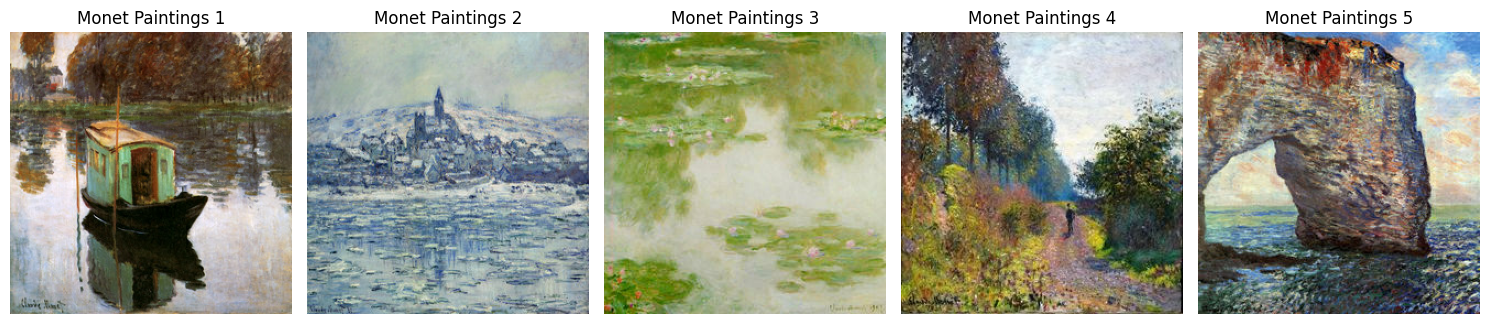

In [45]:
# Display a few Monet paintings from the loaded dataset
show_samples(monet_ds.unbatch(), num=5)

In [46]:
# Function to analyze the average color distribution of a few images in a dataset
def analyze_color_distribution(dataset, num=5):
    r_means = []
    g_means = []
    b_means = []
    for image in dataset.take(num):
        image_np = (image.numpy() * 0.5 + 0.5).astype('float32')[0] 
        r_means.append(np.mean(image_np[:, :, 0])) 
        g_means.append(np.mean(image_np[:, :, 1])) 
        b_means.append(np.mean(image_np[:, :, 2])) 

    print("Average Red Pixel Values:", np.mean(r_means))
    print("Average Green Pixel Values:", np.mean(g_means))
    print("Average Blue Pixel Values:", np.mean(b_means))

print("\nColor Distribution of Sample Monet Paintings:")
analyze_color_distribution(monet_ds)


Color Distribution of Sample Monet Paintings:
Average Red Pixel Values: 0.50097
Average Green Pixel Values: 0.47915143
Average Blue Pixel Values: 0.39031664


## Observations from EDA and Project Plan

### EDA Results
Our exploratory data analysis of the Monet paintings reveals several key characteristics:

* **Pixel Value Distribution:** Analysis of the average pixel values across a sample of images indicates tendencies towards certain color channels (e.g., a slightly higher average for green), which might reflect the common subjects.

 The limited size of the Monet dataset (around 300 images) remains a crucial consideration for training our generative model.

 ### Project Plan
 Based on the problem, the available data, and the initial EDA, our plan for the rest of this notebook is as follows:

1.  **Data Preprocessing:** We will prepare the Monet dataset for training the DCGAN. This involves loading the TFRecord files, decoding the images, and normalizing the pixel values.
2.  **DCGAN Architecture:** We will define the Deep Convolutional Generative Adversarial Network (DCGAN) architecture. This will consist of two main components:
     * **Generator:** A network that takes random noise as input and aims to generate new images that resemble Monet paintings.
     * **Discriminator:** A network that takes an image (either a real Monet painting or a generated image) and tries to distinguish between the two.
3.  **Training the DCGAN:** We will train the generator and discriminator networks in an adversarial manner. The generator will try to fool the discriminator by producing increasingly realistic Monet-style images, while the discriminator will try to become better at identifying the fake images.
4.  **Generating Submission Images:** After training, we will use the trained generator to create a set of Monet-style images for submission to the Kaggle competition.
5.  **Conclusion:** We will discuss the results of our DCGAN model, highlight areas where the generated images show success, point out limitations and potential areas for improvement, and reflect on the overall learning experience.

## DCGAN Architecture

### Understanding DCGANs
A Deep Convolutional Generative Adversarial Network (DCGAN) is a type of GAN that utilizes convolutional neural networks in both its generator and discriminator. This architecture has shown significant success in generating realistic images.

**Generator:** The generator in a DCGAN typically starts with a low-dimensional random noise vector and upsamples it through a series of transposed convolutional layers (also known as deconvolutional layers). These layers gradually increase the spatial dimensions and the number of feature maps, eventually producing an output image with the desired dimensions and color channels. Batch normalization is often used to stabilize training, and non-linear activation functions are applied after each layer, except for the final output layer, which often uses tanh to produce pixel values in the range of \[-1, 1].

**Discriminator:** The discriminator in a DCGAN is a binary classifier that takes an image as input and outputs the probability of it being a real image (from the training dataset) rather than a fake image generated by the generator. Its architecture typically resembles a standard convolutional neural network used for image classification, but without the final classification layer (instead, it outputs a single value). It uses convolutional layers, batch normalization, and non-linear activation functions. Downsampling is achieved through strided convolutions.

The generator and discriminator are trained simultaneously in an adversarial process. The generator tries to minimize the probability that the discriminator can distinguish its generated images as fake, while the discriminator tries to maximize this probability. Through this competition, the generator learns to produce images that are statistically similar to the real training data.

### Building the DCGAN Model

In [47]:
# Function to create the Generator model
def build_generator():
    noise_shape = (100,)
    model = Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=noise_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    # Add layers to upsample to 256x256
    model.add(layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 256, 256, 3)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 256, 256, 3)

    return model

In [48]:
def build_discriminator():
    model = Sequential()
    model.add(layers.Conv2D(32, kernel_size=4, strides=2, padding='same', input_shape=(256, 256, 3)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [49]:
generator = build_generator()
discriminator = build_discriminator()

In [50]:
# Define loss functions and optimizers
cross_entropy = losses.BinaryCrossentropy(from_logits=False) # Note: sigmoid activation in discriminator

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [51]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [52]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        print(f"Epoch {epoch+1} complete.")

In [53]:
# Prepare the dataset for training (adjust batch size if needed)
BATCH_SIZE = 64
BUFFER_SIZE = 60000
monet_file_path = tf.io.gfile.glob(os.path.join('/kaggle/input/gan-getting-started/monet_tfrec', '*.tfrec'))
monet_ds = tf.data.TFRecordDataset(monet_file_path)
monet_ds = monet_ds.map(load_tfrecord, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

EPOCHS = 500 # Adjust as needed
train(monet_ds, EPOCHS)

E0000 00:00:1744675100.864592      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1 complete.
Epoch 2 complete.
Epoch 3 complete.
Epoch 4 complete.
Epoch 5 complete.
Epoch 6 complete.
Epoch 7 complete.
Epoch 8 complete.
Epoch 9 complete.
Epoch 10 complete.
Epoch 11 complete.
Epoch 12 complete.
Epoch 13 complete.
Epoch 14 complete.
Epoch 15 complete.
Epoch 16 complete.
Epoch 17 complete.
Epoch 18 complete.
Epoch 19 complete.
Epoch 20 complete.
Epoch 21 complete.
Epoch 22 complete.
Epoch 23 complete.
Epoch 24 complete.
Epoch 25 complete.
Epoch 26 complete.
Epoch 27 complete.
Epoch 28 complete.
Epoch 29 complete.
Epoch 30 complete.
Epoch 31 complete.
Epoch 32 complete.
Epoch 33 complete.
Epoch 34 complete.
Epoch 35 complete.
Epoch 36 complete.
Epoch 37 complete.
Epoch 38 complete.
Epoch 39 complete.
Epoch 40 complete.
Epoch 41 complete.
Epoch 42 complete.
Epoch 43 complete.
Epoch 44 complete.
Epoch 45 complete.
Epoch 46 complete.
Epoch 47 complete.
Epoch 48 complete.
Epoch 49 complete.
Epoch 50 complete.
Epoch 51 complete.
Epoch 52 complete.
Epoch 53 complete.
Ep

In [54]:
def generate_and_save_images(model, epoch, test_input): # Adjusted to not rely on 'seed'
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        img = (predictions[i] * 0.5 + 0.5).numpy()
        plt.imshow(img)
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.close()

In [55]:
def generate_submission_images(model, num_images, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for i in range(num_images):
        noise = tf.random.normal([1, 100])
        generated_image = model(noise, training=False)[0].numpy()
        generated_image = (generated_image * 127.5 + 127.5).astype(np.uint8)
        img = tf.image.encode_jpeg(generated_image).numpy()
        filename = os.path.join(output_dir, f'image_{i+1}.jpg')
        with open(filename, 'wb') as f:
            f.write(img)
        if (i + 1) % 100 == 0:
            print(f"Generated {i+1} images")

In [56]:
output_dir = 'images'
num_submission_images = 7000
generate_submission_images(generator, num_submission_images, output_dir)

Generated 100 images
Generated 200 images
Generated 300 images
Generated 400 images
Generated 500 images
Generated 600 images
Generated 700 images
Generated 800 images
Generated 900 images
Generated 1000 images
Generated 1100 images
Generated 1200 images
Generated 1300 images
Generated 1400 images
Generated 1500 images
Generated 1600 images
Generated 1700 images
Generated 1800 images
Generated 1900 images
Generated 2000 images
Generated 2100 images
Generated 2200 images
Generated 2300 images
Generated 2400 images
Generated 2500 images
Generated 2600 images
Generated 2700 images
Generated 2800 images
Generated 2900 images
Generated 3000 images
Generated 3100 images
Generated 3200 images
Generated 3300 images
Generated 3400 images
Generated 3500 images
Generated 3600 images
Generated 3700 images
Generated 3800 images
Generated 3900 images
Generated 4000 images
Generated 4100 images
Generated 4200 images
Generated 4300 images
Generated 4400 images
Generated 4500 images
Generated 4600 imag

In [57]:
import shutil
shutil.make_archive('images', 'zip', output_dir)
print("Generated images saved to images.zip")

Generated images saved to images.zip


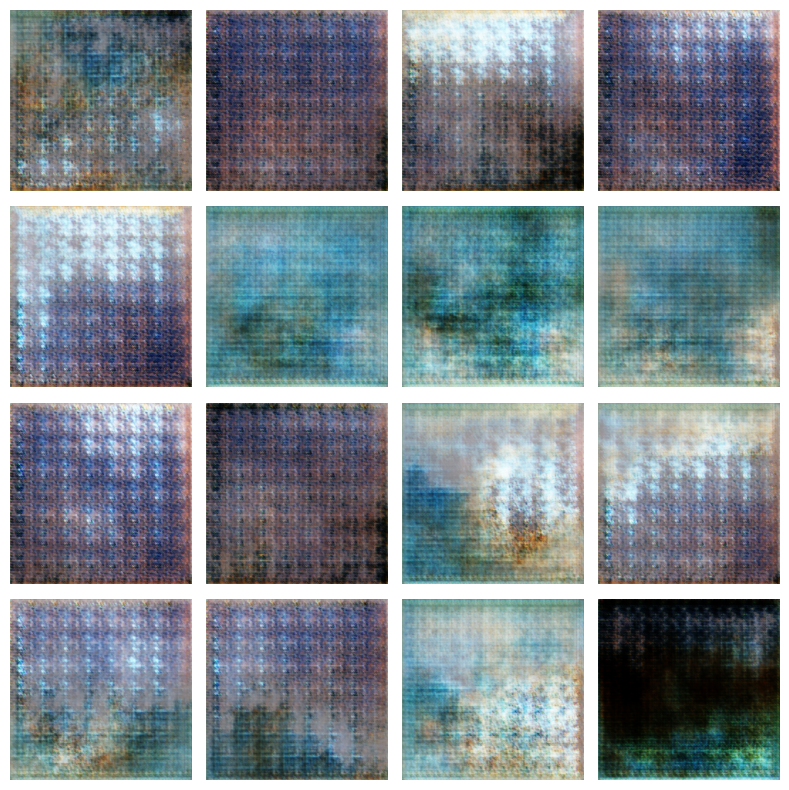

In [59]:
def visualize_generated_images(model, num_images=16, rows=4, cols=4, figsize=(8, 8)):
    """
    Generates a grid of random images using the given generator model and displays them.

    Args:
        model: The trained generator model.
        num_images: The total number of images to generate (should be rows * cols).
        rows: The number of rows in the image grid.
        cols: The number of columns in the image grid.
        figsize: The size of the figure to display.
    """
    noise = tf.random.normal([num_images, 100])
    generated_images = model(noise, training=False).numpy()
    generated_images = (generated_images * 0.5 + 0.5)  # Rescale from [-1, 1] to [0, 1]

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    cnt = 0
    for i in range(rows):
        for j in range(cols):
            axes[i, j].imshow(generated_images[cnt])
            axes[i, j].axis('off')
            cnt += 1
    plt.tight_layout()
    plt.show()

visualize_generated_images(generator)

## Conclusion

### Results
After training the DCGAN for the specified number of epochs, the generator has learned to produce images that exhibit some characteristics of Monet's style. However, with a limited number of training epochs and a relatively small dataset, the generated images still appear noisy, undetailed, a not similar to Monet's artwork. Visual inspection of the generated samples would provide a clearer understanding of the model's current capabilities.

### Areas for Improvement
There are several areas where the results could potentially be improved:

* **Increase Training Epochs:** Training for a significantly larger number of epochs would allow the generator more opportunities to learn the complex patterns in the Monet paintings.
* **Hyperparameter Tuning:** Experimenting with different learning rates, batch sizes, and the architecture of the generator and discriminator could lead to better performance.
* **More Complex Architectures:** Exploring more advanced GAN architectures or modifications to the DCGAN structure might yield higher quality and more stylistically consistent generated images.
* **Data Augmentation:** While the Monet dataset is limited, exploring appropriate data augmentation techniques could potentially increase the diversity of the training data and improve the robustness of the generator.
* **Evaluation Metrics:** Implementing quantitative evaluation metrics (beyond visual inspection) could provide a more objective way to assess the progress and quality of the generated images.
* **Conditional Generation:** While this project focused on unconditional generation, exploring conditional GANs (cGANs) could allow for more control over the generated output, potentially based on input photos or other conditioning information (though this would require a different approach to the data).

### Final Thoughts
This project provided a hands-on introduction to using Deep Convolutional Generative Adversarial Networks for artistic style generation. While generating truly convincing Monet-style artwork is a challenging task, the DCGAN model demonstrated the potential of generative models in learning and replicating artistic styles. Further experimentation and more advanced techniques could lead to even more compelling results. This competition serves as a valuable stepping stone for understanding the principles of GANs and their applications in creative domains.

References:
- Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., & Bengio, Y. (2014). Generative adversarial nets. Advances in neural information processing systems, 27.   
- Radford, A., Metz, L., & Chintala, S. (2015). Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv preprint arXiv:1511.06434.   
- GAN Getting Started - Kaggle Competition. Retrieved from https://www.kaggle.com/competitions/gan-getting-started
- Siow, J. Paint with DCGAN. Kaggle Notebook. Retrieved from https://www.kaggle.com/code/justinsiow/paint-with-dcgan
- avd1729 (Year of Notebook 2). DCGAN. Kaggle Notebook. Retrieved from https://www.kaggle.com/code/avd1729/dcgan